In [1]:
#import required libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from minisom import MiniSom
from PIL import Image 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [2]:
def som_node_to_index(x, y, nx, ny): 
    
    # returns the index of a SOM node given the node's (x,y) coordinate on the map of size (ny, nx)
    #    index 1 is (0,0) on the SOM (top left); index 2 is on the first row, second column
    #    x and y index from zero
    #    nx and ny define the size of the map
    #
    # Examples: 
    #   som_node_to_index(1,1,2,2) returns 4
    #   som_node_to_index(0,1,3,2) also returns 4
    
    bmu_ind = nx*(y) + x + 1
        
    return bmu_ind

In [3]:
def plot_provinces(ax):
    
    # Given a geoaxis (ax), plots the borders of the provinces of Canada
    #
    # Example:
    #     fig = plt.figure()
    #     ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(), aspect = 'auto')
    #     plot_provinces(ax)
    
    provshapes_filename = './Data/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    for provIndex in range(13):#[0,11]:
        provPoly = provshapes['geometry'][provIndex]

        if len(np.shape(provPoly)) == 0: #if only one polygon to plot

            lonBorder,latBorder = provPoly.exterior.coords.xy 
            ax.plot(lonBorder,latBorder,'k', transform = ccrs.PlateCarree(), linewidth = 1)

        else: #if multiply polygons in shape to plot

            for ind in range(len(provPoly)):

                lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
                ax.plot(lonBorder_segment,latBorder_segment,'k', transform = ccrs.PlateCarree(), linewidth = 1)

In [4]:
#load data

filedir = './Data/RGI/' #directory where the Randolph Glacier Inventory data are stored

#load western canada/us hypsometry
filename_hypso = '02_rgi60_WesternCanadaUS_hypso.csv'
df_hypso_west = pd.read_csv(filedir + filename_hypso)

#load alaska hypsometry
filename_hypso = '01_rgi60_Alaska_hypso.csv'
df_hypso_alaska = pd.read_csv(filedir + filename_hypso)

#load western canada/us shapefiles
filename_shape = '02_rgi60_WesternCanadaUS.shp'
df_shape_west = gpd.read_file(filedir + filename_shape)

#load alaska shapefiles
filename_shape = '01_rgi60_Alaska.shp'
df_shape_alaska = gpd.read_file(filedir + filename_shape)

In [5]:
#look at western canada/us data
df_hypso_west.head()

,RGIId,GLIMSId,Area,25,75,125,175,225,275,325,...,3975,4025,4075,4125,4175,4225,4275,4325,4375,4425
0,RGI60-02.00001,G238765E49002N,0.073,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RGI60-02.00002,G238410E49162N,0.262,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RGI60-02.00003,G238791E49163N,0.307,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,RGI60-02.00004,G238399E49166N,0.184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RGI60-02.00005,G238389E49167N,0.274,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#look at alaska data
df_hypso_alaska.head()

,RGIId,GLIMSId,Area,25,75,125,175,225,275,325,...,5725,5775,5825,5875,5925,5975,6025,6075,6125,6175
0,RGI50-01.00001,G213177E63689N,0.360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RGI50-01.00002,G213332E63404N,0.558,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RGI50-01.00003,G213920E63376N,1.685,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,RGI50-01.00004,G213880E63381N,3.681,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RGI50-01.00005,G212943E63551N,2.573,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#the two hypsometry datasets have different elevation ranges; 
#western canada/us begins at 25 m and ends at 4425 m (w/ 50 m intervals) 
#while alaska begins at 25 m and goes to 6175 m (w/)
#need to add columns (w/ 0 area) from 4475m through 6175m to all glaciers in western canada/us 
#then the two dataframes can be concatentated into one dataset

start = np.float(df_hypso_west.columns[-1])+50 #the elevation column that follows the last band in western canada/us
fin = np.float(df_hypso_alaska.columns[-1]) #the last elevation column in alaska
for column in np.arange(start, fin+50, 50): #add each additional column to canada/us dataframe
    df_hypso_west[str(column)] = 0 #all with no area

#concatenate the canada/us + alaska datasets (hypsometry and shape)
df_hypso = pd.DataFrame(data = np.vstack([df_hypso_west.get_values(), df_hypso_alaska.get_values()]), columns = df_hypso_alaska.columns)
df_shape = pd.concat([df_shape_west, df_shape_alaska], sort = True)

In [8]:
#look at hypsometry data

df_hypso.head()

,RGIId,GLIMSId,Area,25,75,125,175,225,275,325,...,5725,5775,5825,5875,5925,5975,6025,6075,6125,6175
0,RGI60-02.00001,G238765E49002N,0.073,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RGI60-02.00002,G238410E49162N,0.262,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RGI60-02.00003,G238791E49163N,0.307,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,RGI60-02.00004,G238399E49166N,0.184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RGI60-02.00005,G238389E49167N,0.274,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#look at shapefile data

df_shape.head()

,Area,Aspect,BgnDate,CenLat,CenLon,Connect,EndDate,Form,GLIMSId,Linkages,...,O2Region,RGIId,Slope,Status,Surging,TermType,Zmax,Zmed,Zmin,geometry
0,0.073,345,20049999,49.0019,-121.235,0,20069999,0,G238765E49002N,9,...,4,RGI60-02.00001,29.0,0,0,0,2135,2039,1938,"POLYGON ((-121.237179 49.00120000000004, -121...."
1,0.262,6,20049999,49.1617,-121.590,0,20069999,0,G238410E49162N,9,...,4,RGI60-02.00002,29.6,0,0,0,2105,1962,1726,POLYGON ((-121.5911819999999 49.15867800000007...
2,0.307,100,20049999,49.1627,-121.209,0,20069999,0,G238791E49163N,9,...,4,RGI60-02.00003,31.0,0,0,0,2309,2127,2002,"POLYGON ((-121.207506 49.16608200000007, -121...."
3,0.184,15,20049999,49.1657,-121.601,0,20069999,0,G238399E49166N,9,...,4,RGI60-02.00004,25.3,0,0,0,1834,1669,1563,POLYGON ((-121.5965409999999 49.16728500000005...
4,0.274,50,20049999,49.1666,-121.611,0,20069999,0,G238389E49167N,9,...,4,RGI60-02.00005,28.5,0,0,0,2101,1937,1668,POLYGON ((-121.6079999999999 49.16802400000006...


In [10]:
#extract glacier values for visualization

cenLon = df_shape['CenLon']
cenLat = df_shape['CenLat']
area = df_shape['Area']
aspect = df_shape['Aspect']
slope = df_shape['Slope']
Zmed = df_shape['Zmed']

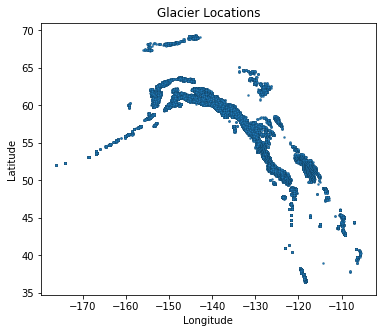

In [11]:
#visualize glacier locations

plt.figure(figsize = (6,5))
plt.scatter(cenLon, cenLat, s=5, linewidth = .1, edgecolor = 'k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Glacier Locations')

plt.show()

## Cluster hypsometry

In [12]:
#prep for clustering: rows are observations, columns are variables

hypso = np.float64(df_hypso.get_values()[:,3:]) #areas at each elevation 
elevation = np.arange(int(df_hypso.columns[3]),int(df_hypso.columns[-1])+50,50) #elevations 

hypso_norm = np.zeros_like(hypso) #normalize hypsometry by its max value (so we cluster shape, not magnitude)
for kk in range(len(hypso_norm)):
    hypso_norm[kk,:] = hypso[kk,:] / np.max(hypso[kk,:])

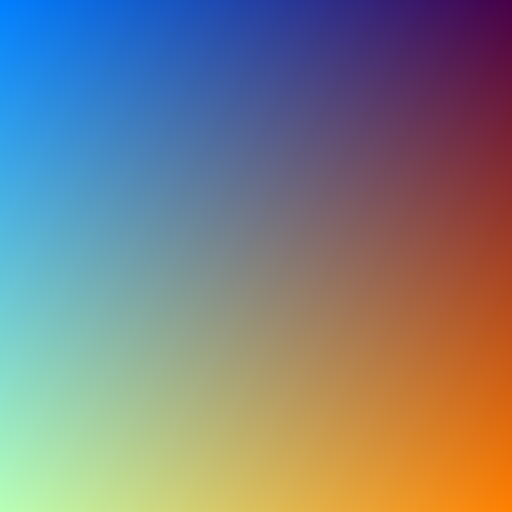

In [13]:
#load 2D colourmap to use for colouring the SOM nodes
#for data and further discussion on 2D colourmaps, see:
#
#     Steiger, M. et al. Explorative analysis of 2D color maps. In Proc. WSCG 2015
#     Conference on Computer Graphic, Visualization, and Computer Vision
#     (eds Gavrilova, M. & Skala, V.) 151–160 (Union Angency, 2015).

colour_base = Image.open('./Data/' + 'teulingfig2.png')
colour_base_array = np.asarray(colour_base)
colour_base

In [14]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

#set random seed for reproducability
np.random.seed(1)

#map size
nx = 8
ny = 8

#input data
data = hypso_norm

#make, initialize, and train the SOM
som = MiniSom(nx, ny, len(data[0]), sigma=np.sqrt(np.mean(nx+ny)), learning_rate=0.3, random_seed=0) # initialization of (ny x nx) SOM
som.pca_weights_init(data)
som.train_random(data, 10000) # trains the SOM with 100 iterations

qnt = som.quantization(data) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(data) #quantization error of map
TE = som.topographic_error(data) #topographic error of map

#calculate the BMU of each observation
bmus = []
for kk in range(len(data)):
    bmus.append(som.winner(data[kk]))
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
        
#compute the frequency of each bmu
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=len(data)

# print(QE, TE)

/Users/samanderson/anaconda3/lib/python3.7/site-packages/minisom.py:304: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


In [15]:
#convert bmus from the (x,y) position on the map to a corresponding integer index

bmus = np.asarray(bmus)
bmu_ind = som_node_to_index(bmus[:,0], bmus[:,1], nx, ny)

In [16]:
#for visualization, assign each bmu/glacier a colour from the 2D map 

bmus_colours = np.zeros((ny, nx, 3))

xbuffer = int(512 / nx / 2)
ybuffer = int(512 / ny / 2)

xpoints = np.array([int(xx) for xx in np.linspace(xbuffer,511-xbuffer,nx)])
ypoints = np.array([int(yy) for yy in np.linspace(ybuffer,511-ybuffer,ny)])

for xx in range(nx):
    for yy in range(ny):
        bmus_colours[yy,xx,:] = colour_base_array[ypoints[yy], xpoints[xx], :]
        
cGlacier = np.zeros((len(hypso), 3))
for gg in range(len(hypso)):
    indx = bmus[gg][0]
    indy = bmus[gg][1]
    cGlacier[gg,:] = bmus_colours[indy, indx,:]

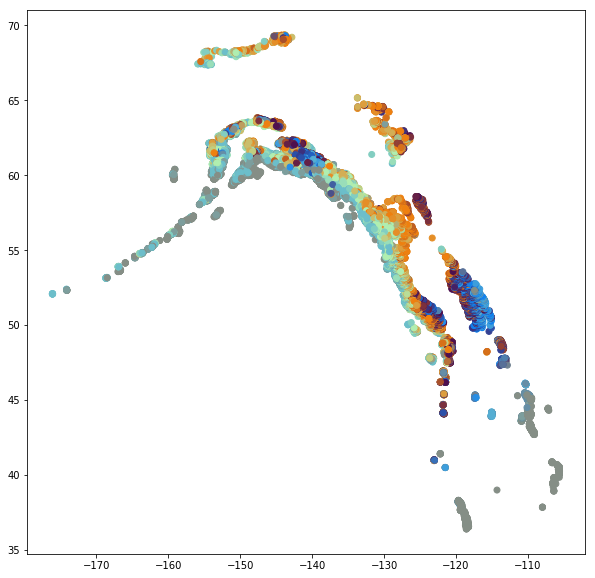

In [17]:
#visualize map in space of clustering results

plt.figure(figsize = (10,10))
plt.scatter(cenLon, cenLat, c = cGlacier / 256)
# plt.xlim((-120,-115))
# plt.ylim((49,54))
# plt.colorbar()

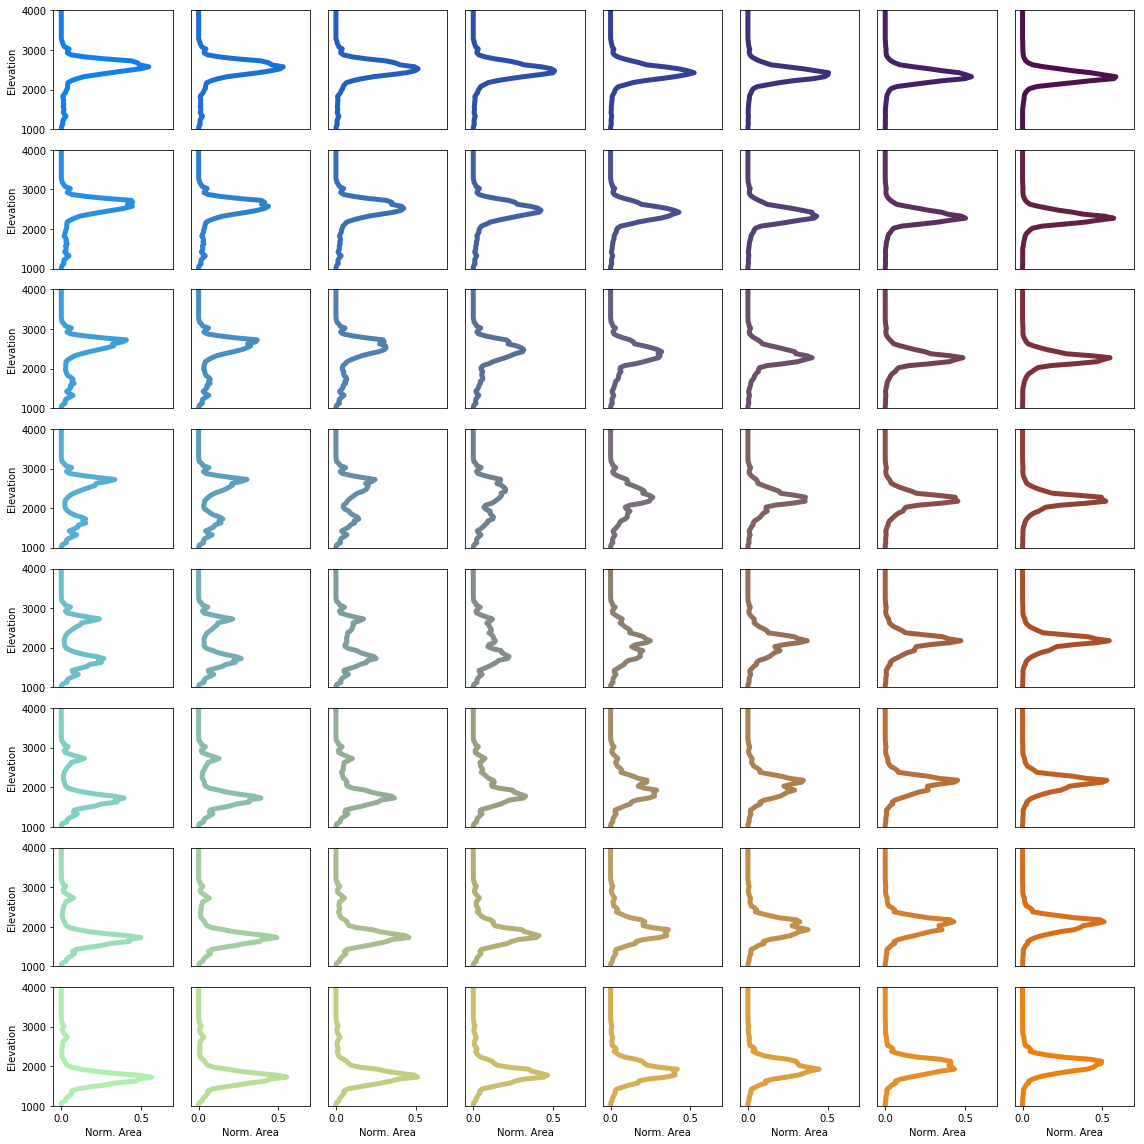

In [18]:
#visualize SOM

saveIt = 0

fig, axes = plt.subplots(nrows = ny, ncols = nx, figsize = (2*ny, 2*nx))

for kk, ax in enumerate(axes.flatten()):   

    indx = inds[kk][1]
    indy = inds[kk][0]
    ax.plot(bmu_patterns[indx][indy], elevation, color = bmus_colours[indy, indx,:]/256, linewidth = 5)
    ax.set_xlim((-0.05,0.7))
    ax.set_ylim((1000,4000))
    
    #axis tick labels only on left and bottom sides of figure
    if np.mod(kk,nx) == 0:
        ax.set_yticks([1000,2000,3000,4000])
        ax.set_ylabel('Elevation')
    else:
        ax.set_yticks([])
        
    if kk > nx*(ny-1) - 1:
        ax.set_xticks([0,0.5])
        ax.set_xlabel('Norm. Area')    
    else:
        ax.set_xticks([])       
    
fig.tight_layout()

if saveIt:
    plt.savefig('SOM_patterns.png', bbox_inches  = 'tight', dpi = 150)

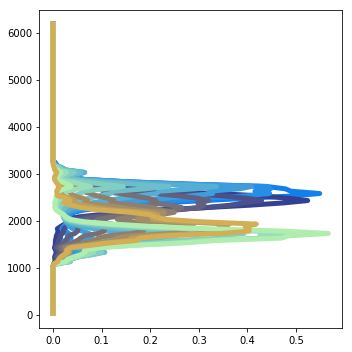

In [19]:
#visualize a few cluster patterns on same figure

plt.figure(figsize=(5,5))
for kk in range(nx*ny):   

    if np.mod(kk,4)==0:

        indx = inds[kk][1]
        indy = inds[kk][0]
        plt.plot(bmu_patterns[indx][indy], elevation, color = bmus_colours[indy, indx,:]/256, linewidth = 5)
#         plt.xticks([])
#         plt.yticks([])
    
plt.tight_layout()

In [20]:
#define features to add to maps

#national borders
borders = cfeature.NaturalEarthFeature(
    category = 'cultural',
    name = 'admin_0_boundary_lines_land',
    scale = '10m',
    edgecolor='k',
    facecolor='None'
)

#state borders (not including coastlines or national borders)
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor = 'None',
    edgecolor ='k'
)

#coastlines
coasts = cfeature.GSHHSFeature(
    scale = 'intermediate',
    levels = [1],
    facecolor = 'None',
    edgecolor = 'k',
    linewidth = 1
)

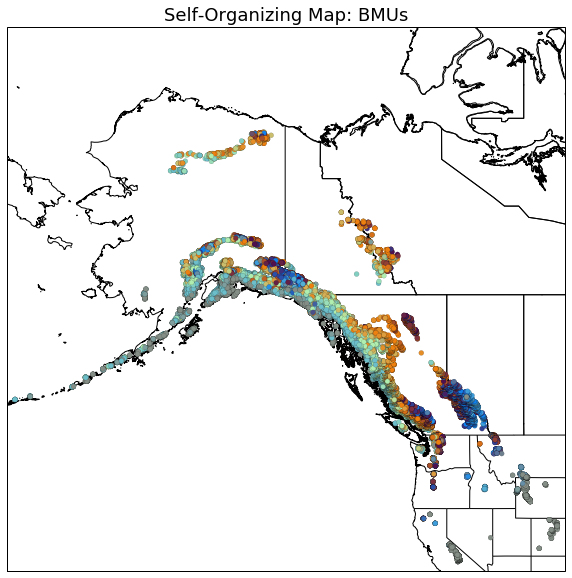

In [21]:
#whole region

saveIt = 0

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(), aspect = 'auto')

ax.add_feature(coasts, zorder = 1)
# ax.add_feature(borders, zorder = 2)
ax.add_feature(states, zorder = 3)
plot_provinces(ax = ax)
ax.scatter(cenLon, cenLat, c = cGlacier / 256, s = 25, edgecolor = 'k',  linewidth = .1, transform = ccrs.PlateCarree(), zorder = 4)
ax.set_title('Self-Organizing Map: BMUs', fontsize = 18)

east = np.max(cenLon) + 1
west = np.min(cenLon) - 1
north = np.max(cenLat) + 1
south = np.min(cenLat) - 1

ax.set_extent([west,east,south,north])

if saveIt:
    plt.savefig('BMUs_whole_region.png', bbox_inches  = 'tight', dpi = 150)

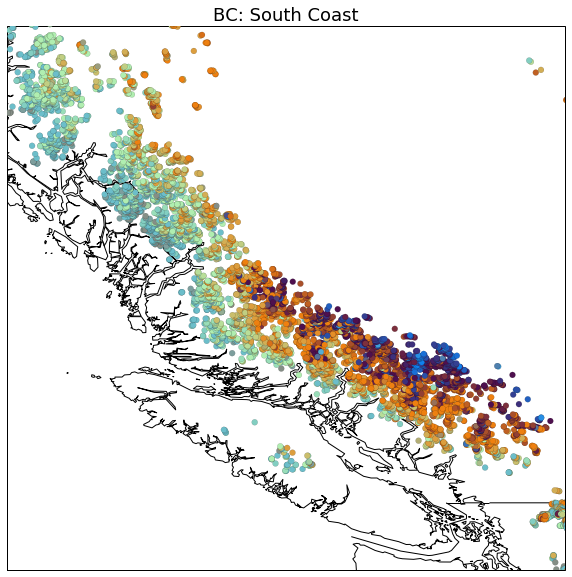

In [22]:
#coast

saveIt = 0

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(), aspect = 'auto')

ax.add_feature(coasts)
ax.add_feature(borders)
ax.add_feature(states)
ax.scatter(cenLon, cenLat, c = cGlacier / 256, s = 35, edgecolor = 'k',  linewidth = .1, transform = ccrs.PlateCarree(), zorder = 4)
ax.set_title('BC: South Coast', fontsize = 18)

east = -130
west = -121.5
north = 55.5
south = 48

ax.set_extent([west, east, south, north])

if saveIt:
    plt.savefig('BMUs_BC.png', bbox_inches  = 'tight', dpi = 150)

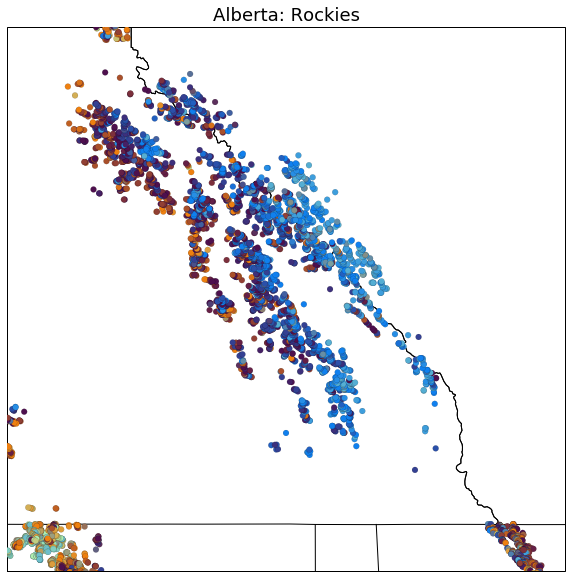

In [23]:
#rockies

saveIt = 0

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(), aspect = 'auto')

ax.add_feature(states)
plot_provinces(ax = ax)
ax.scatter(cenLon, cenLat, c = cGlacier / 256, s = 35, edgecolor = 'k',  linewidth = .1, transform = ccrs.PlateCarree(), zorder = 4)
ax.set_title('Alberta: Rockies', fontsize = 18)

east = -122
west = -113
north = 54
south = 48.5

ax.set_extent([west, east, south, north])

if saveIt:
    plt.savefig('BMUs_AB.png', bbox_inches  = 'tight', dpi = 150)

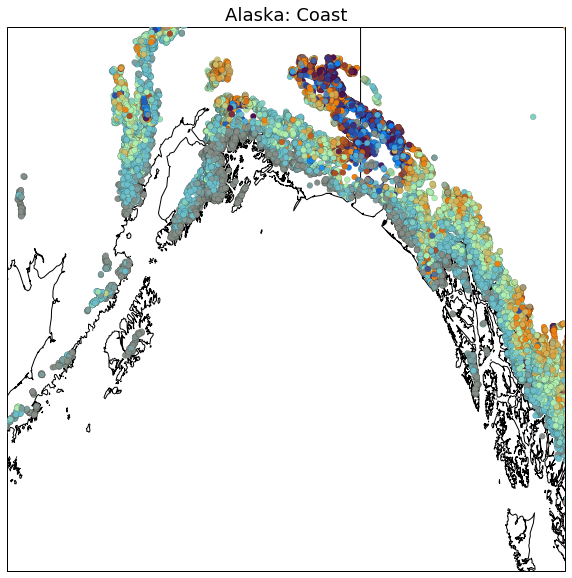

In [24]:
#alaskan coast

saveIt = 0

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(), aspect = 'auto')

ax.add_feature(coasts)
ax.add_feature(borders)
ax.add_feature(states)
ax.scatter(cenLon, cenLat, c = cGlacier / 256, s = 35, edgecolor = 'k',  linewidth = .1, transform = ccrs.PlateCarree(), zorder = 4)
ax.set_title('Alaska: Coast', fontsize = 18)

east = -130
west = -160
north = 62
south = 53

ax.set_extent([west, east, south, north])

if saveIt:
    plt.savefig('BMUs_AK.png', bbox_inches  = 'tight', dpi = 150)